# Introduction
In this paper we will be pricing index basket options, using a combination of time-series forecasts and copula based simulation methods. Specifically, we will be pricing basket options on the DAX, AEX, FTSE 100 Nikkei 225, S&P 500, S&P/TSX indices, with a payoff function $\max{(\text{average return of indices}-k, 0)}$, for various strikes $k$, with a time to maturity of one month.

To do this, we will first fit several GARCH based volatility forecasts to each index, assuming normal, Student's-t, and skewed Student's-t residuals. Then, we will fit a multivariate-t distribution to our data, apply the probability transform to our residuals, and fit a Student's-t copula to the result. Goodness of fit tests will be conducted for each model. For each assumed residual distribution, we will use Monte Carlo methods to forecast the payoff of our basket option. We will conclude by simulating the performance of the covered call strategy, and backtesting our results. 


## Background Concepts

We assume that the reader has a basic understanding of time-series models, model fitting, and options.
First, let us define our time-series models.

### ARCH Model

Let us do a brief overview of the Autoregressive Conditional Heteroskedasticity (ARCH) model. Let $\{y_t\}$  be a time-series. Let $\{\epsilon_t\}$ denote the error terms (known as residuals, with respect to a mean process). We will assume for each time-series that the mean process is constant. We assume that $\epsilon _t = \sigma_t z_t$, where $\sigma_t$ repsents the time-dependent volatility/standard deviation, and $z_t$ is a white noise process (a stochastic process with mean 0, constant volatility, and no autocorrelation). We will assume that our white noise processes have a constantly volatility of 1.

We forecast conditional volatility as: $$\sigma^2_t = \alpha_0 + \sum_{i=1}^{q} {\alpha_i \epsilon^2_{t-i}}$$

for some $\alpha_0 > 0, \alpha_i \geq 0$ where q represents the order of the ARCH process (i.e. the number of previous residuals to consider).

The main feature of this model is that it is able to capture volatility clustering in the data, by considering past "shocks" or errors. 

### GARCH Model
The above can be generalized, by also including an moving average of the previous volatilities. This results in a Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model.

We forecast conditional volatility as: $$\sigma^2_t = \omega + \sum_{i=1}^{q} {\alpha_i \epsilon^2_{t-i}}+\sum_{i=1}^{p} {\beta_i \sigma^2_{t-i}} $$ for some $\omega > 0, \alpha_i \geq 0, \beta_i \geq 0$ where q represents the order of the ARCH process, and p represents the order of the GARCH process (i.e. the number of previous volatilities to consider).

This model has the added capability of capturing the persistence of previous volatility.

For an intuitive understanding of the parameters, consider the yield of US Government bonds. Note that in the bond market, there are few market moving events, apart from the occasional interest rate change. The response to each interest rate change is generally small, as the effect has been priced in, yielding low values of $\alpha_i$. However, once volatility increases, it tends to be persistant, yielding high values of $\beta_i$. For empirical justification of this situation, see the fitted parameters [here](#Fit-GARCH-Models).




#### Noise Processes
We will assume that our noise process follows one of the following:\
1. A Standard Normal distribution $N(0,1)$,\
2. A Standard Student's-t distribution with a fitted degrees of freedom $t_\nu (0,1)$,\
3. A Skewed Student's-t distribution with fitted degrees of freedom and skew parameter\
We assume that the reader is familiar with the first two distributions, and thus we will only highlight the latter distribution.

#### Skewed Student's-t distribution

We use the density function given by Hansen in [[4]](#references), and refer the reader there for a more indepth analysis:


$$g(z|\eta, \lambda) =
\begin{cases}
    bc \left(1 + \frac{1}{\eta - 2} \right) \left( \frac{bz + a}{1 + \lambda} \right)^{-(\eta + 1)/2} & \text{if } z < -a/b, \\
    bc \left(1 + \frac{1}{\eta - 2} \right) \left( \frac{bz + a}{1 + \lambda} \right)^{-(\eta + 1)/2} & \text{if } z \geq -a/b,
\end{cases}$$

where $2 < \eta < \infty$ and $-1 < \lambda < 1$, and $ a = 4 \lambda c \left( \frac{\eta - 2}{\eta - 1} \right) $, $b^2 = 1 + 3A \lambda ^2 - a^2$, $c = \frac{\Gamma\left( \frac{\eta + 1}{2} \right)}{\sqrt{\pi (\eta - 2)}} \left( \frac{\eta}{2} \right)$ 


The idea behind this distribution is to generalize the Student's-t distribution, to allow for skewness. Fortunately, the arch library, from [[9]](#references), allows us to easily sample from this skewed Student's-t distribution.


## Preliminary Work

### Import Libraries
We will use:  
1. The yfinance library from [[1]](#references) to download our data,  
2. the tabulate library from [[2]](#references) for printing,  
3. the numpy library from [[5]](#references),  
4. the matplotlib library from [[6]](#references) for data visualization,  
5. the pandas library from [[7]](#references) for data structures, 
6. the statsmodels library from [[8]](#references) for graphing autocorrelation functions and fitting t-copulas,  
7. the arch library from [[9]](#references) for fitting GARCH models, and conducting goodness of fit tests,  
8. the scipy library from [[10]](#references) for fitting multivariate models, conducting simulations, goodness of fit and hypothesis testing


In [1]:
import yfinance as yf
import tabulate as tab
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.distributions.copula.api import StudentTCopula
from statsmodels.graphics.tsaplots import plot_acf
from arch import arch_model
from arch.univariate import SkewStudent
from scipy.stats import norm, t
from scipy.optimize import minimize
from scipy.stats import ttest_ind

### Import Data
This cell imports index data from Yahoo Finance, using the yFinance library

In [19]:
# List of ticker symbols for each index
all_tickers = ["^GDAXI", "^AEX", "^FTSE", "^N225", "^GSPC", "^GSPTSE", "^TYX"]   # DAX, AEX, FTSE 100, Nikkei 225, S&P 500, S&P/TSX Composite, US Treasury Yield
index_datasets = {}
# Loop over each ticker symbol to fetch the data
for ticker in all_tickers:
    # Retrieve the historical data starting from November 20, 1992
    index = yf.Ticker(ticker)
    #Save to dictionary
    index_datasets[ticker] = index.history(start="1992-11-20")   #(start="1992-11-20")
    # Convert the Date column to Datetime
    (index_datasets[ticker]).index = pd.to_datetime((index_datasets[ticker]).index.normalize().tz_localize(None))
    index_datasets[ticker] = round(index_datasets[ticker],12)

### Compute log-returns
We merge all of the data stored in the index_datasets dictionary into one Pandas dataframe. We sample the data on a monthly basis, using a forward fill to account for any missing dates. The forward fill is required to account for different exchanges having different holidays. We then compute the monthly log-returns for each index. We then drop all data apart from the date and monthly log-returns from our dataframe.

In [3]:
# Initialize a DataFrame to store merged data
merged_data = pd.DataFrame()
# Loop over each ticker symbol to fetch the data
for ticker in all_tickers:
    index_data = index_datasets[ticker]
    # Extract only the Date and Close columns, reset the index
    close_data = (index_data[['Close']]).copy()
    close_data.rename(columns={'Close': ticker},inplace=True)
    # Merge with the previously merged data
    if merged_data.empty:merged_data = close_data
    else:merged_data = pd.merge(merged_data, close_data, on='Date')

for ticker in all_tickers: merged_data[ticker] = merged_data[ticker].ffill() #Forward fill missing data

merged_data = merged_data.resample("ME").last() #Resample at end of each month
merged_data[:] = np.log(1+merged_data.pct_change()) #Compute Log Returns
merged_data.dropna(inplace=True)#Drop blank entries in first row (if any)

# Model Fitting

## Compute Empirical Moments

In [4]:
print("Empirical moments for each index's monthly log-returns:\n")
moments_df = pd.DataFrame(columns=['Mean', 'Variance', 'Skewness', 'Kurtosis'], index=all_tickers)

# Calculate and print empirical moments for each ticker
for ticker in all_tickers:
    data = merged_data[ticker] 
    moments_df.loc[ticker, 'Mean'] = data.mean()
    moments_df.loc[ticker, 'Variance'] = data.var()
    moments_df.loc[ticker, 'Skewness'] = data.skew()
    moments_df.loc[ticker, 'Kurtosis'] = data.kurtosis()
display(moments_df)

Empirical moments for each index's monthly log-returns:



,Mean,Variance,Skewness,Kurtosis
^GDAXI,0.006691,0.003432,-0.824921,2.75046
^AEX,0.005077,0.002829,-0.934099,2.595312
^FTSE,0.00283,0.001509,-0.698239,1.198767
^N225,0.002085,0.003134,-0.584036,1.236407
^GSPC,0.00687,0.001819,-0.661003,1.198823
^GSPTSE,0.005288,0.001735,-1.062607,3.589094
^TYX,-0.001296,0.004282,-0.132169,3.96768


## Fit GARCH Models
Here, we first fit a Students-t GARCH model to the log-return data for each index, using the arch library. To do this, we must first decide what order $(p)$ to use for the GARCH terms $(\sigma^2_t)$, and what order $(q)$ to use for the ARCH Terms $(\epsilon_t)$.

### Choose (p,q)
We will test different pairs of $(p,q)$, and choose the one with the lowest average Akaike Information Criterion (AIC) across all distributions and indices. Note that we are actually fitting the GARCH model to 100 times the log-return data, as recommended by the library documentation. This is done to improve numerical stability. 

In [5]:
distributions = ("normal","t","skewt")
combinations = [(i, j) for i in range(1, 5) for j in range(1, 5)]
# i.e. [(1,1),(1,2),...,(1,4),(2,1),(2,2),...,(4,4)]

best_AIC = pd.DataFrame(np.inf,columns=all_tickers, index = distributions)
best_pair = pd.DataFrame(columns=all_tickers, index = distributions)

for dist in distributions:
    for (p,q) in combinations:
        for ticker in all_tickers:
            # as suggested by the documentation, we scale our data to improve numerical stability
            model = arch_model(merged_data[ticker]*100, vol="Garch", p=p, q=q, dist=dist, rescale=False)  
            aic = model.fit(options={'maxiter': 10000, 'ftol': 1e-8},disp="off").aic
            #Record best (p,q) for each dist/index pair
            if best_AIC.loc[dist,ticker] > aic:
                best_AIC.loc[dist,ticker] = aic
                best_pair.loc[dist,ticker] = (p,q)
display(best_pair)
display(best_AIC)

,^GDAXI,^AEX,^FTSE,^N225,^GSPC,^GSPTSE,^TYX
normal,"(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 4)"
t,"(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 4)"
skewt,"(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 1)","(1, 4)"


,^GDAXI,^AEX,^FTSE,^N225,^GSPC,^GSPTSE,^TYX
normal,2417.101759,2309.746993,2106.259017,2418.134960,2151.502832,2142.290945,2449.473316
t,2393.009971,2305.313312,2102.273644,2415.909522,2150.634685,2126.277537,2424.195133
skewt,2380.483416,2291.146543,2086.902825,2404.967300,2128.086483,2109.856289,2424.355801


The above results suggest that GARCH(1,1) models best fit our data, for all distribution/equity index pairs. Also, the skewed Student's-t GARCH(1,1) model has the best fit for all equity indices, as evident by its relatively lower AIC. Thus, it is best if we set the order of our GARCH and ARCH terms to (1,1), for each index and distribution.


### Fit GARCH(1,1) models

Next, we will save our normal, Student's-t and skewed Student's-t GARCH(1,1) models, as well as their standardized residuals. We also model the US 30 Yield Treasury Bond yield, to illustrate the situation in our introduction. 

In [6]:
fitted_models ,params, std_residuals = {}, {}, {}
#Fit each GARCH model, store models in fitted_models dictionary and standarized residuals in std_residuals dataframe
for dist in distributions:
        # as suggested by the documentation, we scale our data to improve numerical stability
    fitted_models[dist] = {ticker: arch_model(merged_data[ticker]*100, vol="Garch", p=1, q=1, dist=dist, rescale=False)
                                        .fit(options={'maxiter': 1000, 'ftol': 1e-8},disp="off") 
                                    for ticker in all_tickers}   
    std_residuals[dist] = pd.DataFrame([fitted_models[dist][ticker].resid / fitted_models[dist][ticker].conditional_volatility
                                        for ticker in all_tickers],index = all_tickers).T
#Creates a dataframe with the fitted parameters from each model
print("Fitted parameters for each model:")
for dist in distributions:
    params[dist] = pd.DataFrame(columns=all_tickers)
    for ticker in all_tickers:
        params[dist][ticker] = fitted_models[dist][ticker].params
    print("\nModel: "+dist,end="")
    display(params[dist])

Fitted parameters for each model:

Model: normal

,^GDAXI,^AEX,^FTSE,^N225,^GSPC,^GSPTSE,^TYX
mu,0.962595,0.815584,0.467662,0.306701,0.861011,0.840098,-0.254837
omega,4.472001,3.101404,1.466476,12.145274,1.016401,2.388316,7.062766
alpha[1],0.195138,0.267256,0.172319,0.114560,0.188905,0.349941,0.251255
beta[1],0.684832,0.635464,0.736607,0.496925,0.764643,0.562227,0.581669



Model: t

,^GDAXI,^AEX,^FTSE,^N225,^GSPC,^GSPTSE,^TYX
mu,1.176980,0.905821,0.597849,0.473077,0.966314,0.827391,-0.243223
omega,3.303976,3.456597,1.657939,2.203972,1.003940,1.468203,0.616889
alpha[1],0.188118,0.251224,0.186542,0.048784,0.193731,0.191023,0.061737
beta[1],0.728181,0.632739,0.713412,0.878970,0.763205,0.735646,0.927331
nu,5.893826,9.413719,9.095880,12.441729,12.054167,6.716557,5.073379



Model: skewt

,^GDAXI,^AEX,^FTSE,^N225,^GSPC,^GSPTSE,^TYX
mu,0.861619,0.704819,0.439732,0.291820,0.825220,0.601850,-0.335107
omega,3.478294,2.689154,1.551337,2.877517,0.961396,1.092803,0.744395
alpha[1],0.172326,0.233617,0.159156,0.065356,0.192949,0.156737,0.076044
beta[1],0.728239,0.674386,0.735369,0.839261,0.759284,0.786065,0.910711
eta,6.781941,11.166049,13.521038,18.893520,15.622132,8.196171,5.420261
lambda,-0.288247,-0.300320,-0.304656,-0.262524,-0.352774,-0.340294,-0.088599


Recall that we scaled our log-returns by a factor of $100$ before fitting each model. Hence, our mean returns (mu) above are scaled by a factor of $100$, while our baseline variances (omega) are scaled by a factor of $100^2$.

We note that, in each model, the Nikkei 225 returns have a low alpha parameter, suggesting a lack of volatility clustering. Additionally, when compared to the other indices, we note that the Nikkei 225 and S&P 500 returns demonstrate thinner tails, as demonstrated by the relatively greater degrees of freedom in both the classical and skewed Student's-t GARCH models. We observe that each index's returns are negatively skewed, as evident by the lambda parameter in the skewed Student's-t GARCH models. From here on, we will only focus on equity indices, as they are the main focus of this study.

In [7]:
tickers = ["^GDAXI", "^AEX", "^FTSE", "^N225", "^GSPC", "^GSPTSE"] #Drop "^TYX"
merged_data = merged_data[tickers]
for dist in distributions: std_residuals[dist] = std_residuals[dist][tickers]

## GARCH Goodness of Fit Tests

### Plot ACF of Standardized Residuals
We plot the ACF of the residuals of each GARCH, and display them side by side for comparison.

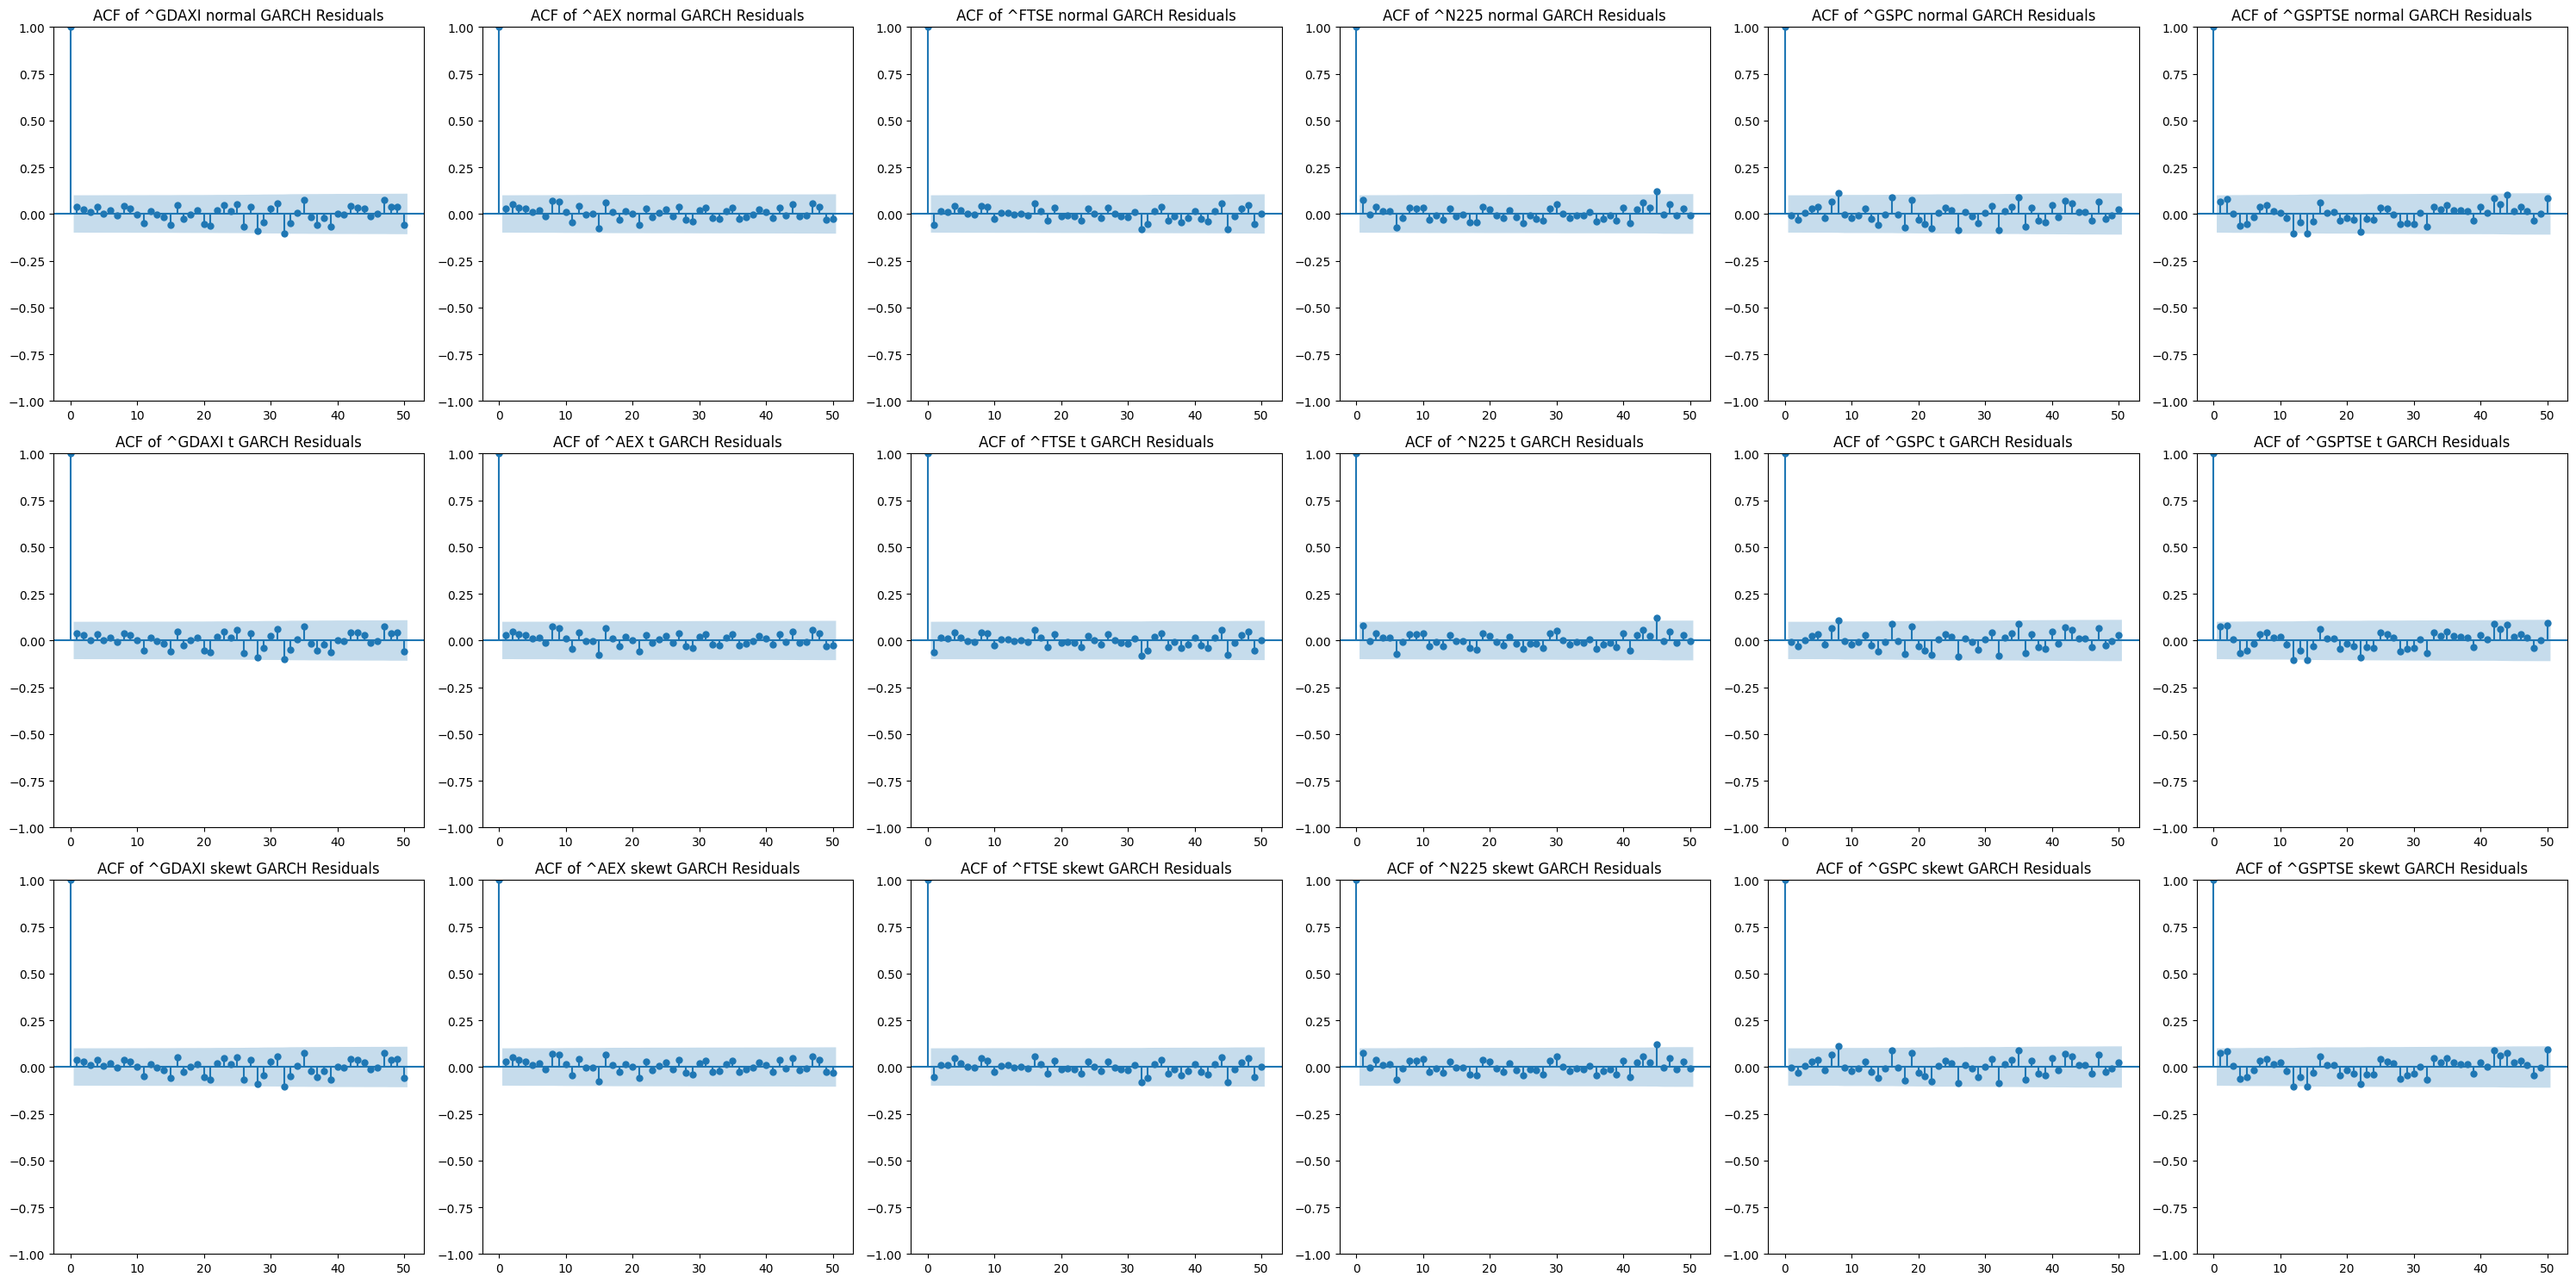

In [8]:
fig, axes = plt.subplots(3, len(tickers), figsize=(5 * len(tickers), 5*3))
for i in range(len(distributions)):
    for j in range(len(tickers)):
        dist, ticker = distributions[i], tickers[j]
        plot_acf(std_residuals[dist][ticker],lags = 50, ax = axes[i][j])
        axes[i][j].set_title('ACF of ' + ticker + " " + dist + ' GARCH Residuals')
plt.tight_layout()

The above results suggest that there is little autocorrelation in the standarized residuals of our fitted GARCH models.

### Plot ACF of Squared Standardized Residuals

We also plot the ACF of the squared residuals of each GARCH.

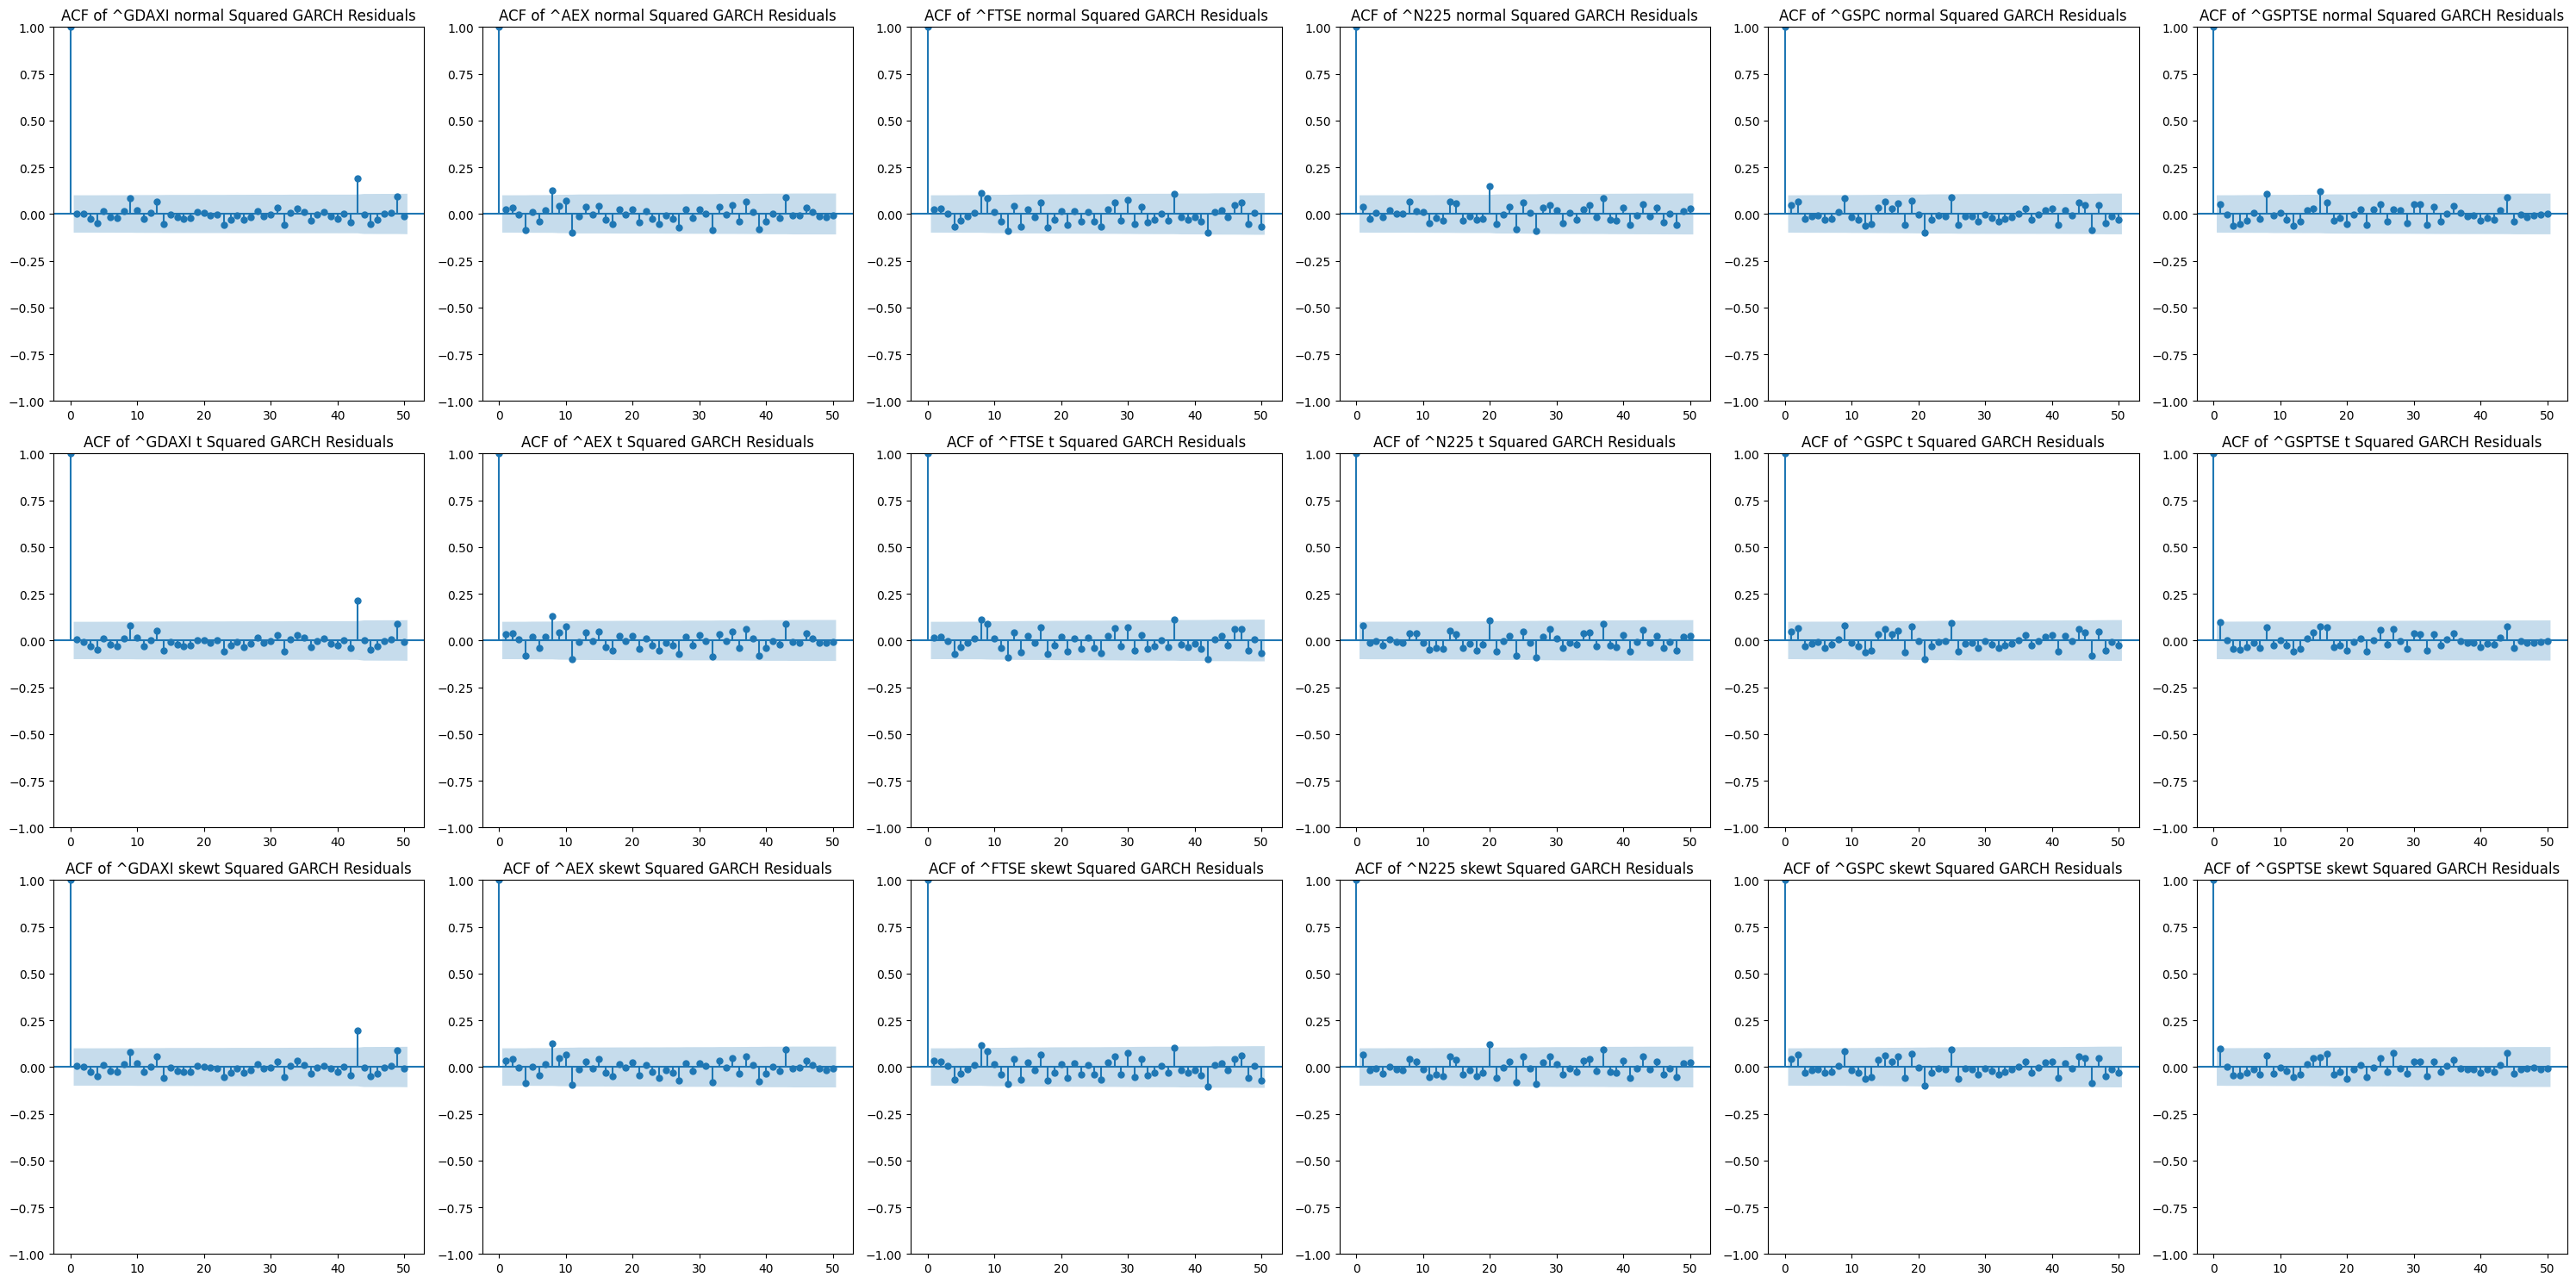

In [9]:
fig, axes = plt.subplots(3, len(tickers), figsize=(5 * len(tickers), 5*3))
for i in range(len(distributions)):
    for j in range(len(tickers)):
        dist, ticker = distributions[i], tickers[j]
        plot_acf(std_residuals[dist][ticker]**2,lags = 50, ax = axes[i][j])
        axes[i][j].set_title('ACF of ' + ticker + " " + dist + ' Squared GARCH Residuals')
plt.tight_layout()

The above results suggest that there is little autocorrelation in the standarized squared residuals of our fitted GARCH models.

### Plot QQ Plot for residuals

We also conduct a QQ Plot of the standardized residuals of each GARCH.

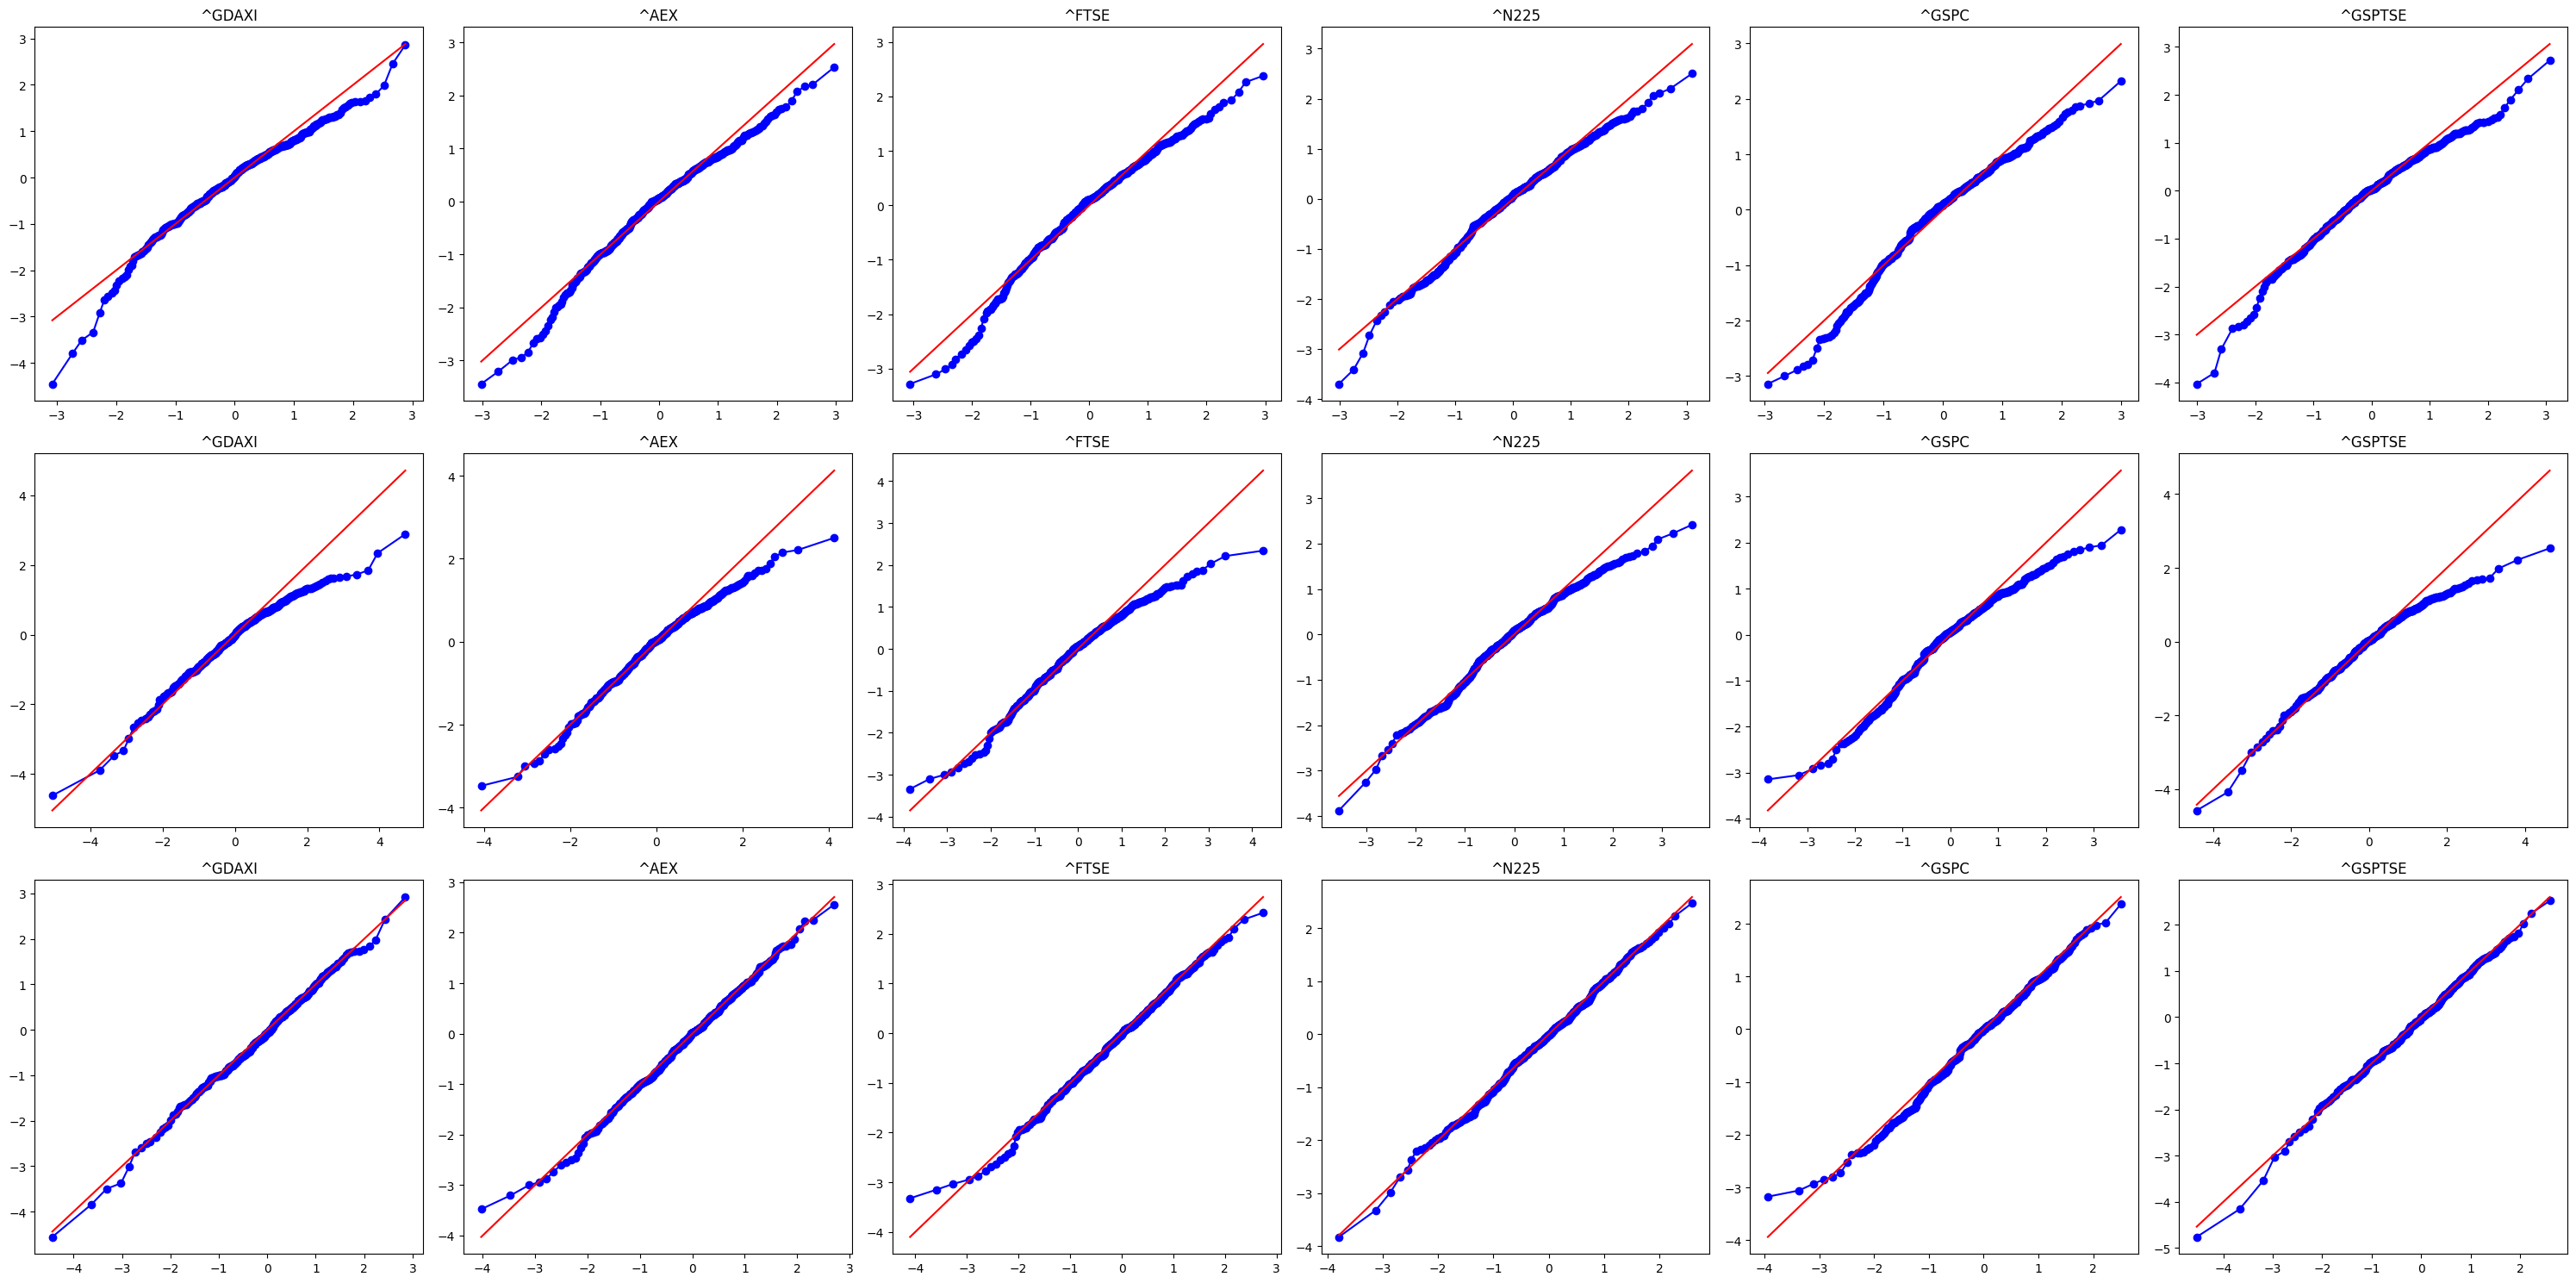

In [10]:
fig, axes = plt.subplots(3, len(tickers), figsize=(5 * len(tickers), 5*3))
for i in range(len(distributions)):
    
    quantiles = (np.arange(1, len(merged_data) + 1) - 0.5) / len(merged_data)

    for j in range(len(tickers)):  # Get theoretical quantiles
        dist, ticker = distributions[i], tickers[j]
        if dist == 'normal': theoretical_quantiles  =  np.quantile(norm.rvs(0,1,10000), quantiles)
        elif dist == 't':
            nu = params[dist][ticker]['nu']
            theoretical_quantiles  =  np.quantile(t.rvs(nu,0,1,10000), quantiles)
        elif dist == 'skewt': 
            eta = params[dist][ticker]['eta']
            lambda_param = params[dist][ticker]['lambda']
            skew_t_rvs = SkewStudent().simulate(parameters=[eta, lambda_param])
            theoretical_quantiles  =  np.quantile(skew_t_rvs(10000), quantiles)
            
        sorted_std_residuals = np.quantile(std_residuals[dist][ticker],quantiles) #Sample Quantiles
        axes[i][j].plot(theoretical_quantiles,sorted_std_residuals,color = "blue", marker = 'o') #QQ Plots
        axes[i][j].plot(theoretical_quantiles,theoretical_quantiles,color = "red")
        axes[i][j].set_title(ticker)
    plt.tight_layout()    

The above results suggest that the skewed Student's-t distribution has the best fit, across all indices. However, most of the our models predict slightly more extreme negative shocks than the data suggests, as evident by bottom left regions in the above QQ Plots.

## Fit Multivariate Model

### Compute Spearman's Variance-Covariance Matrix
Using the standardized residuals from our Student's t GARCH model, we calculate the Spearman correlation & covariance of the standardized residuals.

In [11]:
spearman_cov = {}
print("Spearman Correlation Matrix of Standardized Residuals")
for dist in distributions:
    spearman_cov[dist] = pd.DataFrame(index=tickers,columns=tickers)
    for ticker_1 in tickers:
        for ticker_2 in tickers:
            #Rank residuals
            ranked_residuals_1 = pd.Series(std_residuals[dist][ticker_1]).rank(method='average')
            ranked_residuals_2 = pd.Series(std_residuals[dist][ticker_2]).rank(method='average') 
            #Compute Spearman Correlation Coeff./Covariance 
            spearman_cov[dist].loc[ticker_1,ticker_2] = np.corrcoef(ranked_residuals_1,ranked_residuals_2)[0][1]
    print("GARCH Distribution: ",dist)

display(spearman_cov['normal'],spearman_cov['t'],spearman_cov['skewt'])

#spearman_cov[dist] = spearman_cov[dist].to_numpy(dtype=float) #convert to numpy array for later

Spearman Correlation Matrix of Standardized Residuals
GARCH Distribution:  normal
GARCH Distribution:  t
GARCH Distribution:  skewt


,^GDAXI,^AEX,^FTSE,^N225,^GSPC,^GSPTSE
^GDAXI,1.0,0.834567,0.722668,0.528286,0.715864,0.639892
^AEX,0.834567,1.0,0.748302,0.527376,0.716041,0.643392
^FTSE,0.722668,0.748302,1.0,0.413915,0.684363,0.675111
^N225,0.528286,0.527376,0.413915,1.0,0.512309,0.436195
^GSPC,0.715864,0.716041,0.684363,0.512309,1.0,0.729924
^GSPTSE,0.639892,0.643392,0.675111,0.436195,0.729924,1.0


,^GDAXI,^AEX,^FTSE,^N225,^GSPC,^GSPTSE
^GDAXI,1.0,0.834778,0.722214,0.531196,0.713858,0.639495
^AEX,0.834778,1.0,0.747903,0.53113,0.715048,0.648171
^FTSE,0.722214,0.747903,1.0,0.415055,0.682193,0.678865
^N225,0.531196,0.53113,0.415055,1.0,0.515219,0.442805
^GSPC,0.713858,0.715048,0.682193,0.515219,1.0,0.732767
^GSPTSE,0.639495,0.648171,0.678865,0.442805,0.732767,1.0


,^GDAXI,^AEX,^FTSE,^N225,^GSPC,^GSPTSE
^GDAXI,1.0,0.835828,0.724327,0.53121,0.716047,0.641312
^AEX,0.835828,1.0,0.749276,0.532076,0.716959,0.648551
^FTSE,0.724327,0.749276,1.0,0.416492,0.684318,0.678965
^N225,0.53121,0.532076,0.416492,1.0,0.514127,0.445039
^GSPC,0.716047,0.716959,0.684318,0.514127,1.0,0.732812
^GSPTSE,0.641312,0.648551,0.678965,0.445039,0.732812,1.0


### Fit Student's-t Copula
Next, we will fit our Student's-t copula to our normal, Student's-t and skewed Student's-t GARCH marginal residuals. To do this, we will use the Spearman correlation matrices $\Sigma_{COR}$ from above. We can numerically estimate our fitted degrees of freedom $\nu$, with the constraint that $\nu > 2$, by using scipy's minimize function, applied to our copula's log likelihood function. 

In [12]:
u,fitted_df = {},{}
def negative_tcopula_log_likelihood(nu,corr,x):
    copula = StudentTCopula(corr=corr,df = nu, k_dim=corr.shape[0])
    return -1*sum(copula.logpdf(row) for row in x)
options = {'maxiter': 10000, #Max iterations
            'gtol': 1e-12, #Tolerance for convergence
            'disp': True } #Display warnings
for dist in distributions:
    t_model = t.fit(std_residuals[dist].to_numpy())
    u[dist] = t.cdf(std_residuals[dist].to_numpy(),t_model[0],t_model[1],t_model[2])
    fitted_df[dist] = minimize(negative_tcopula_log_likelihood,10, args = (spearman_cov[dist],u[dist]),bounds = [(2,1000)],options = options).x
display(pd.DataFrame(fitted_df,index=["Fitted df"]))

,normal,t,skewt
Fitted df,11.335846,11.031743,11.044519


#### Sampling Procedure

Following the procedure in "Copula Methods in Finance", we can sample from our Student's t-copula using the following algorithm:

1. Find the Choelsky Decomposition A of R, where R is our Spearman Corr. Matrix
2. Simulate $n$ i.i.d. $N(0,1)$ random variables $z_i$, set $z=(z_1,z_2,...,z_n)$
3. Set $X = Az$
4. Simulate $s\sim\chi^2_\nu$ independently of $z$
5. Set $x = \sqrt{\frac{\nu}{s}}y$
6. Set $u_i = F_\nu (x_i)$ for $i=1,2,...,n$ where $F_nu$ represents the univariate Student's t c.d.f. with $\nu$ degrees of freedom 

We can then set $t_i = F^{-1}_i (u_i)$ for $i=1,2,...,n$ where $F_i^{-1}$ represents the inverse c.d.f for $T_i$. Here, each $t_i$ represents a simulated standardized residual. Conveniently, the statsmodels StudentTCopula class allows us to sample from our copula directly. We will use this instead to conduct 100,000 samples from our copula. Then, applying the marginal inverse c.d.f's component wise, we get 100,000 simulations for our standardized residuals.

In [13]:
copulas = {dist: StudentTCopula(corr=spearman_cov[dist],
                                df = fitted_df[dist], 
                                k_dim=spearman_cov[dist].shape[0]) for dist in distributions}

def inverse_marginal(x,dist): #given a vector of quantiles, return inverse
    marginals = []
    for ticker in tickers:
        if dist == "normal" : marginals.append(norm.ppf(x[:,tickers.index(ticker)]))
        elif dist == "t": marginals.append(t.ppf(x[:,tickers.index(ticker)],df = params[dist][ticker]['nu']))
        elif dist == "skewt": marginals.append((SkewStudent().ppf(pits = x[:,tickers.index(ticker)],
                                    parameters=[params[dist][ticker]['eta'],params[dist][ticker]['lambda']])))
    return pd.DataFrame(np.array(marginals).T,columns = tickers)

def get_simulated_t(dist, num_samples = 100000): #function to create samples from our copula, and convert to marginals
    return inverse_marginal(copulas[dist].rvs(num_samples),dist)

#### Plot QQ Plot for marginal copula samples

We will plot QQplots of our marginal samples drawn from our copula, compared to our GARCH residuals. We expect there to be a strong fit, as our copula is fitted to the transformed residuals.

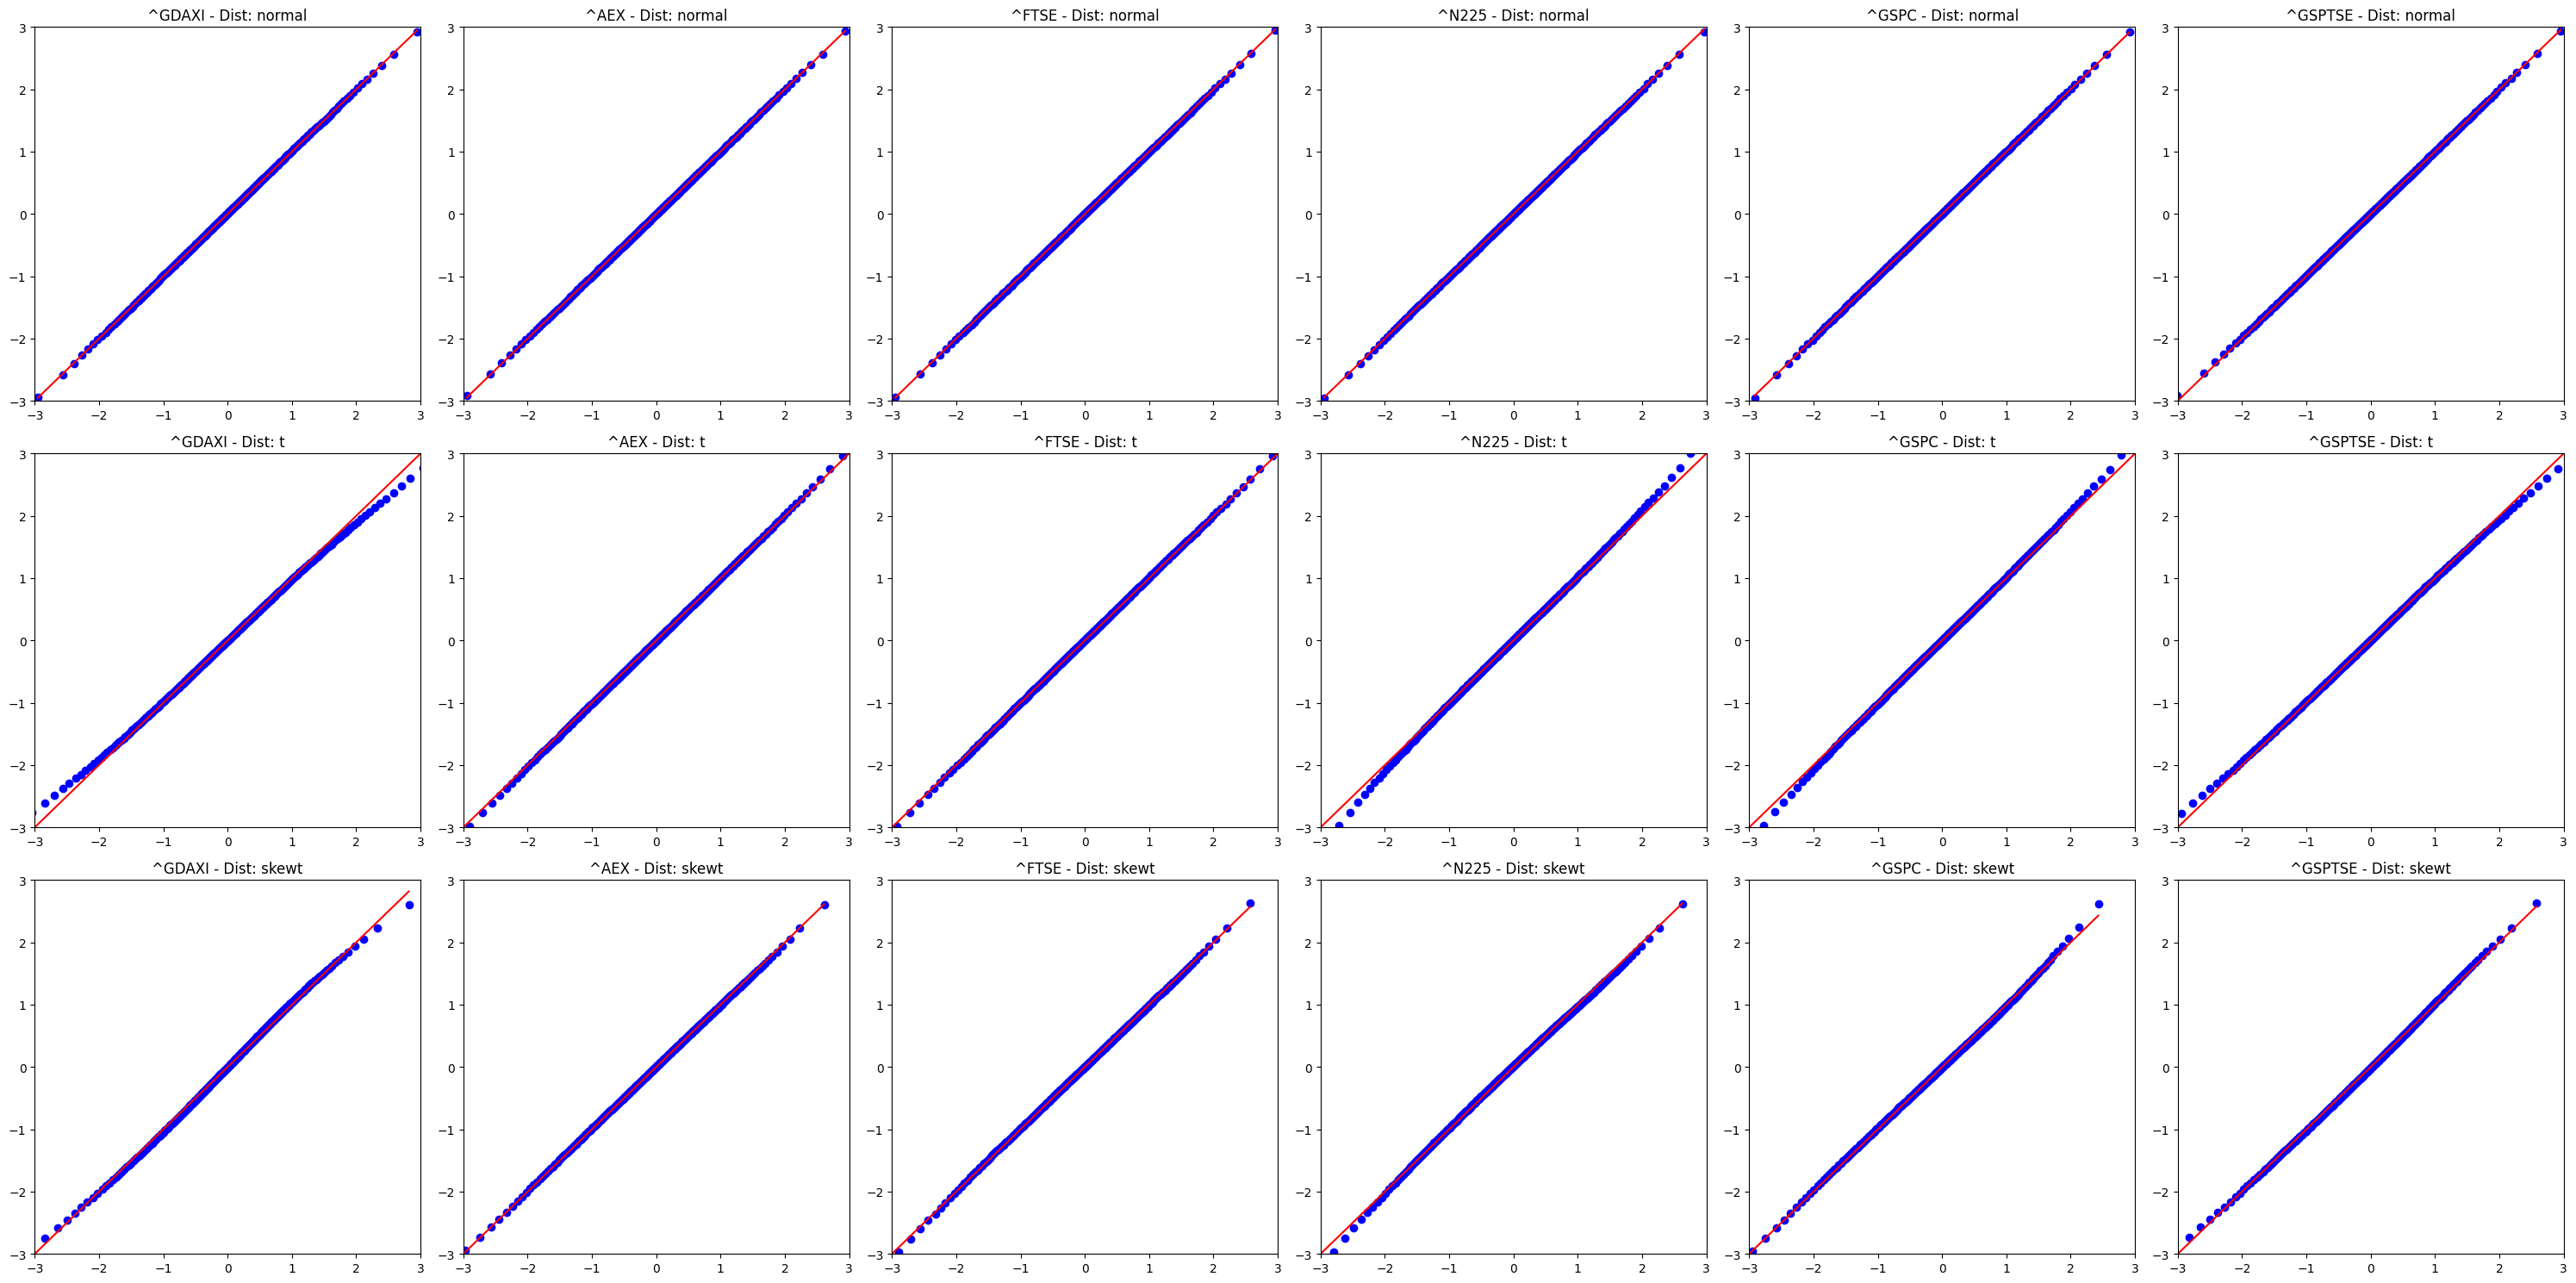

In [14]:
num_samples = 100000
fig, axes = plt.subplots(3, len(tickers), figsize=(5 * len(tickers), 5*3))
for i in range(len(distributions)):
    n = 300
    quantiles = (np.arange(1, n + 1) - 0.5) / n
     #Get simulated results for comparison

    for j in range(len(tickers)):
        dist, ticker, theoretical_quantiles = distributions[i], tickers[j], []
        if dist == 'normal': theoretical_quantiles =  np.quantile(norm.rvs(0,1,num_samples), quantiles)
        elif dist == 't':theoretical_quantiles =  np.quantile(t.rvs(params[dist][ticker]['nu'],0,1,num_samples), quantiles)
        elif dist == 'skewt':  
            skew_t_rvs = SkewStudent().simulate(parameters=[params[dist][ticker]['eta'], params[dist][ticker]['lambda']])
            theoretical_quantiles  =  np.quantile(skew_t_rvs(num_samples), quantiles)

        simulated_quantiles = np.quantile(get_simulated_t(dist),quantiles)
        axes[i][j].plot(theoretical_quantiles,theoretical_quantiles,color = "red")
        axes[i][j].scatter(theoretical_quantiles,simulated_quantiles,color = "blue", marker = 'o')
        axes[i][j].set_xlim(-3,3)
        axes[i][j].set_ylim(-3,3)
        axes[i][j].set_title(ticker+str(" - Dist: "+dist)) 
    plt.tight_layout()

At least on a marginal level, our copula accurately models the standardized residuals from our GARCH models.

# Forecasting

## Forecast One Period Return

We can forecast the one period ahead return as follows:  
1. Forecast the conditional volatility of each index using our GARCH models.  
2. Multiply our n-simulated standardized residuals by our conditional volatility forecasts - this gives n raw residual simulations for each index.  
3. Add our mean log-return to each residual forecast - this yields a one-period ahead forecast for each index, following our dependence structure.  

,Simulated Mean Returns:
normal,0.007969
t,0.008981
skewt,0.007052


Simulated Mean Option Payoffs:

,normal,t,skewt
strike,,,
0.01,0.011895,0.013408,0.010567
0.02,0.007815,0.009205,0.006386
0.03,0.004868,0.006115,0.003539
0.04,0.002888,0.003954,0.001823
0.05,0.001623,0.002502,0.000885


Simulated Density of Simple Returns:


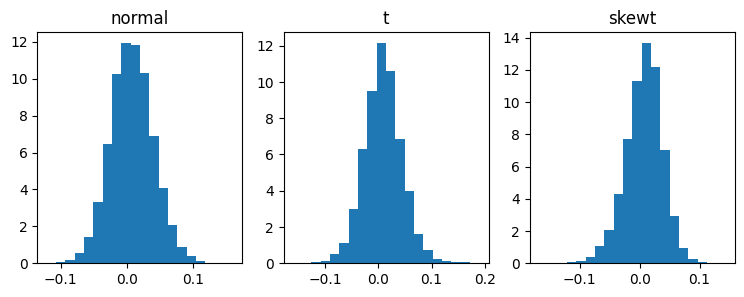

In [15]:
forecast_dfs = {}

def compute_forecast(dist, cond_vol_index = -1, num_samples = 10000):
    forecasts = {}
    simulated_results = get_simulated_t(dist,num_samples)
    for ticker in tickers:
        forecasts[ticker] = params[dist][ticker]['mu']/100 +\
                simulated_results[ticker]*\
                fitted_models[dist][ticker].conditional_volatility.iloc[cond_vol_index]/100
    return pd.DataFrame(forecasts)

strikes = [0.01,0.02,0.03,0.04,0.05]
simulated_prices = pd.DataFrame(index = strikes, columns = ['normal','t','skewt'])
simulated_prices.index.name = "strike"
fig, axes = plt.subplots(1, 3, figsize=(3 * 3, 3))

for dist in distributions:
    forecasts = compute_forecast(dist,-1 )
    forecast_dfs[dist] = np.exp(pd.DataFrame(forecasts)) - 1 #convert to simple returns for computing payoff
    #Compute and plot basket returns
    forecast_dfs[dist]["Average"] = forecast_dfs[dist].mean(axis=1) 
    axes[distributions.index(dist)].hist(forecast_dfs[dist]["Average"], density = True, bins = 20)
    axes[distributions.index(dist)].set_title(dist)
    #Compute simulated payoffs
    for k in strikes:
        simulated_prices.loc[k,dist] = np.maximum(forecast_dfs[dist]["Average"] - k,0).mean()

display(pd.DataFrame([forecast_dfs[dist]["Average"].mean() for dist in distributions], distributions, columns = ["Simulated Mean Returns:"]))

print("Simulated Mean Option Payoffs:",end = "")
display(simulated_prices)

print("Simulated Density of Simple Returns:")
plt.show()

## Historical Payoffs

Here we compute the historical payoff of our basket option, for various strikes, at each month in our dataset.

Empirical Average Simple Return: 0.006013059812587044


,Historical Avg. Payoff
Strike,
0.01,0.013428
0.02,0.008964
0.03,0.005610
0.04,0.003312
0.05,0.001880


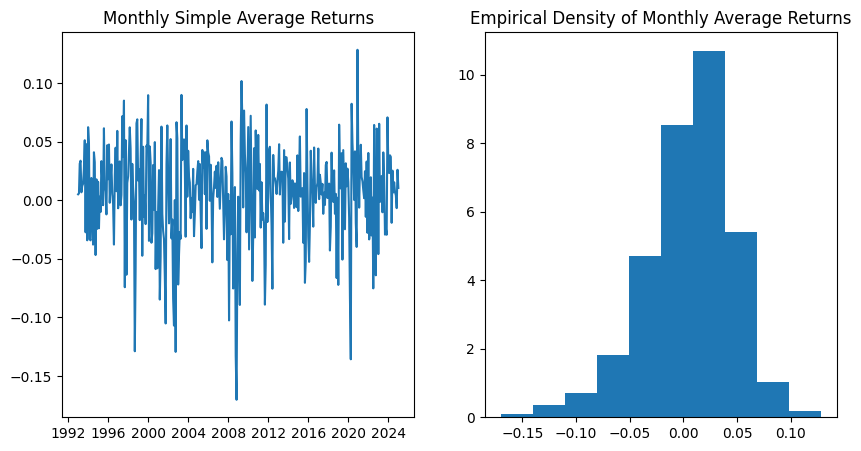

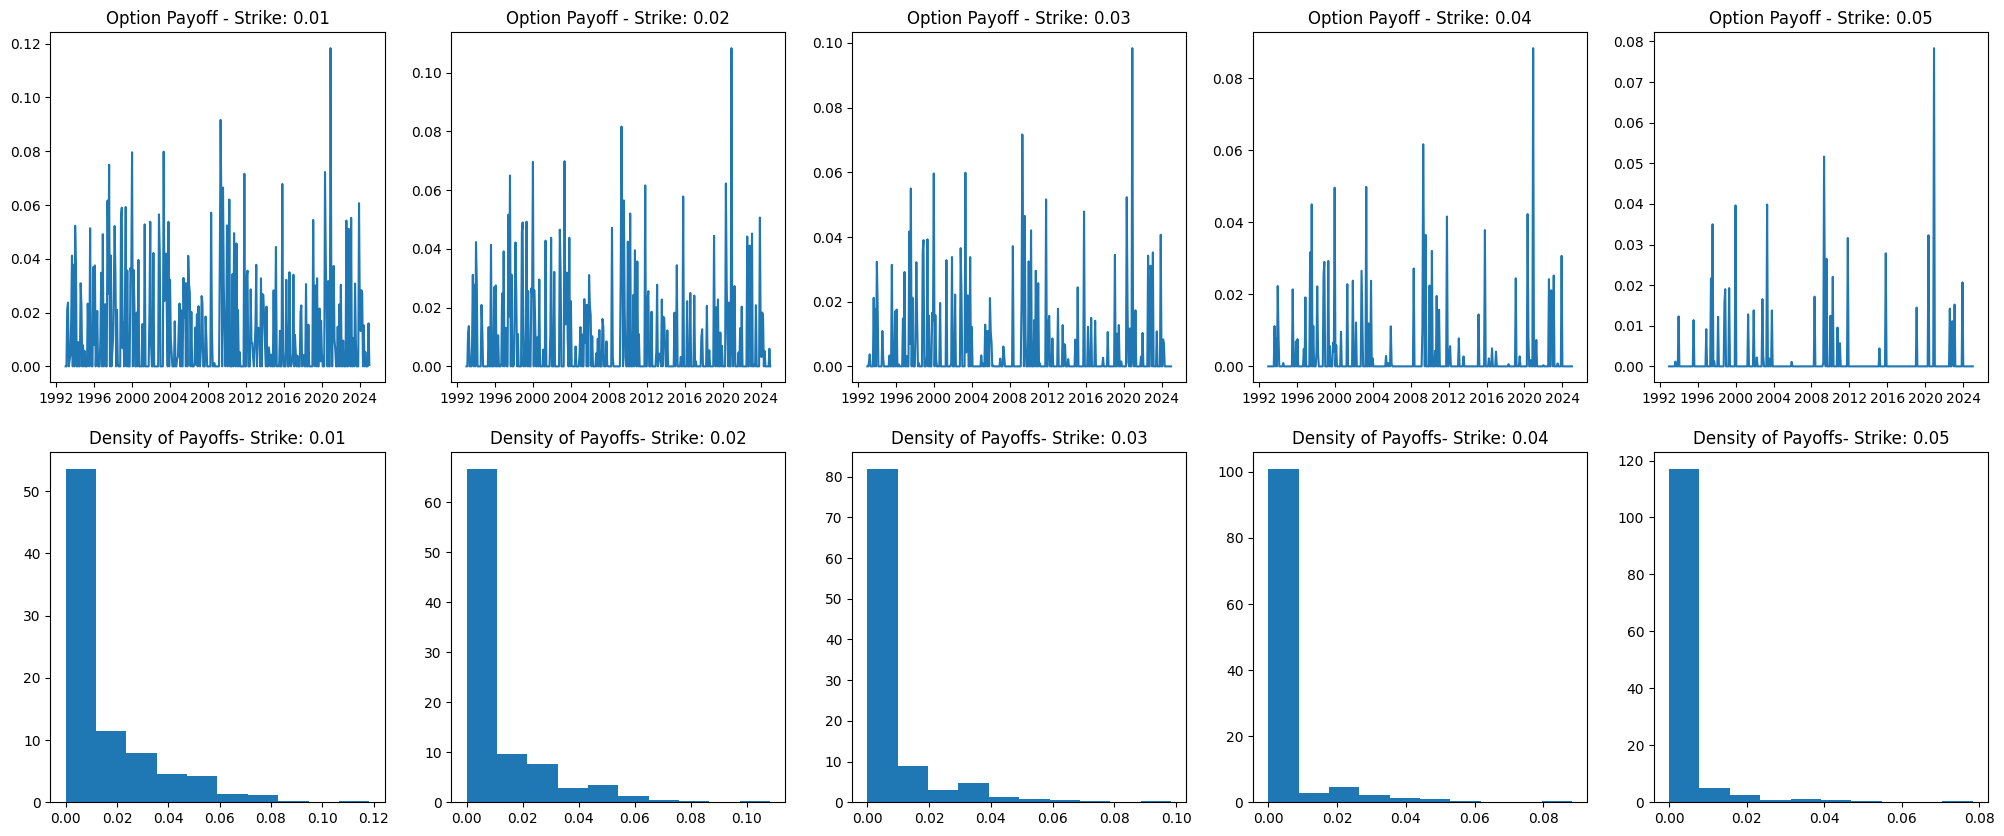

In [17]:
merged_data["Simple Average Return"] = np.exp(merged_data[tickers]).mean(axis=1) - 1

print("Empirical Average Simple Return:",str(merged_data["Simple Average Return"].mean()))
for k in strikes: merged_data["Basket Payoff, strike:",k] = np.maximum(merged_data["Simple Average Return"] - k,0)

display(pd.DataFrame([merged_data["Basket Payoff, strike:",k].mean() for k in strikes],index=pd.Index(strikes,name = 'Strike'), columns = ['Historical Avg. Payoff']))

fig, axes = plt.subplots(1, 2, figsize=(5 * 2, 5))

axes[0].plot(merged_data["Simple Average Return"])
axes[0].set_title("Monthly Simple Average Returns")
axes[1].hist(merged_data["Simple Average Return"], density  = True)
axes[1].set_title("Empirical Density of Monthly Average Returns")
plt.show()

fig, axes = plt.subplots(2, len(strikes), figsize=(5* len(strikes), 10 ))

for i in range(len(strikes)):
    k = strikes[i]
    axes[0][i].plot(np.maximum(merged_data["Simple Average Return"] - k, 0))
    axes[0][i].set_title("Option Payoff - Strike: "+str(k))
    axes[1][i].hist(np.maximum(merged_data["Simple Average Return"] - k, 0), density = True)
    axes[1][i].set_title("Density of Payoffs- Strike: "+str(k))




## Conduct Historical Simulation

Next, we compute the conditional volatility of our log returns. We then compute 10000 simulations at each month, to estimate the basket option payoff at time t. We repeat this process assuming different conditional volatility distributions. We then compare our estimates (red) to the historical payoffs (blue). The shaded region represents the upper and lower 5% quantiles of our forecasted basket returns.

Within Bounds: 0.9714285714285714
Above Bounds: ['2020-11-30']
Below Bounds: ['1998-08-31' '2001-09-30' '2002-09-30' '2008-01-31' '2008-09-30'
 '2008-10-31' '2011-08-31' '2020-02-29' '2020-03-31' '2022-06-30']
Within Bounds: 0.9818181818181818
Above Bounds: []
Below Bounds: ['1998-08-31' '2008-01-31' '2008-09-30' '2008-10-31' '2011-08-31'
 '2020-02-29' '2020-03-31']
Within Bounds: 0.9766233766233766
Above Bounds: ['1999-12-31' '2020-11-30']
Below Bounds: ['1998-08-31' '2008-01-31' '2008-09-30' '2008-10-31' '2011-08-31'
 '2020-02-29' '2020-03-31']


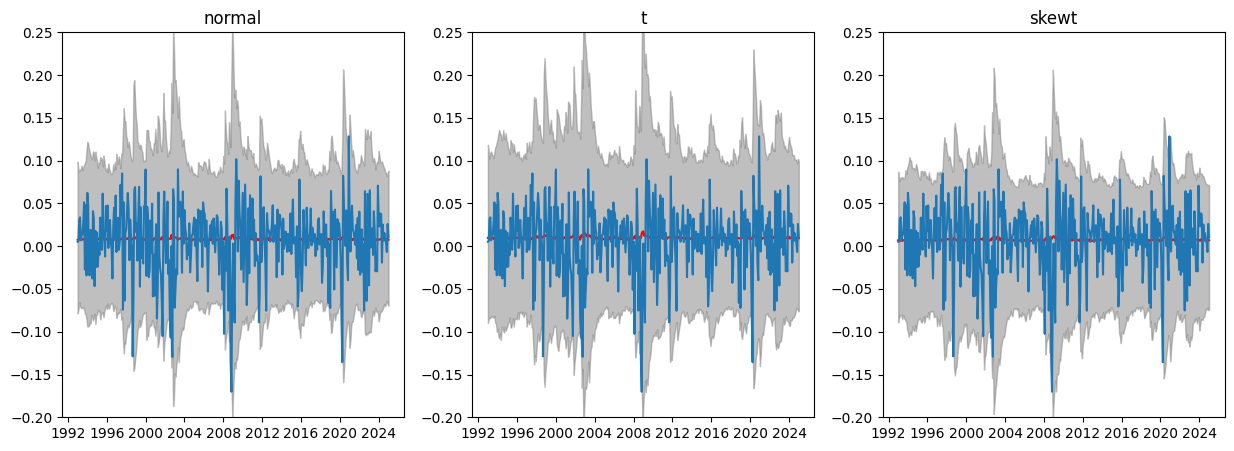

In [18]:
forecasts = {}
forecasted_avg_return = {}
forecasted_95p = {}
forecasted_5p = {}

timesteps = len(merged_data["Simple Average Return"])
fig, axes = plt.subplots(1, 3, figsize=(5 * 3, 5))

for j in range(len(distributions)):
    dist = distributions[j]
    forecasts[dist] = []
    forecasted_avg_return[dist] = np.empty(timesteps)
    forecasted_95p[dist] = np.empty(timesteps)
    forecasted_5p[dist] = np.empty(timesteps)

    for i in range(timesteps):
        forecasts[dist].append(np.exp(compute_forecast(dist,i,3000)) - 1)
        forecasted_avg_return[dist][i] = forecasts[dist][i].mean(axis=None)
        forecasted_95p[dist][i] = np.quantile(forecasts[dist][i],0.975)
        forecasted_5p[dist][i] = np.quantile(forecasts[dist][i],0.025)

    outside_upper_bounds = merged_data["Simple Average Return"] > forecasted_95p[dist]
    outside_lower_bounds = merged_data["Simple Average Return"] < forecasted_5p[dist]
    percent_outside_bounds = (sum(outside_upper_bounds) +sum(outside_lower_bounds))/timesteps

    print("Within Bounds: ",end="")    
    print(1 - percent_outside_bounds)
    if percent_outside_bounds > 0:
        print("Above Bounds:",(merged_data["Simple Average Return"].index[outside_upper_bounds].date.astype(str)))
        print("Below Bounds:",(merged_data["Simple Average Return"].index[outside_lower_bounds].date.astype(str)))

    axes[j].plot(merged_data["Simple Average Return"].index,forecasted_avg_return[dist], color = "red")
    axes[j].plot(merged_data["Simple Average Return"].index,merged_data["Simple Average Return"])
    axes[j].fill_between(merged_data["Simple Average Return"].index,forecasted_5p[dist],forecasted_95p[dist],color = "gray", alpha = 0.5)
    axes[j].set_ylim(-0.2,0.25)
    axes[j].set_title(dist)
plt.show()

Our models fail to accurately model the returns of the basket. This is expected, as we assumed a constant mean for each model, and have created forecasts by computing the average of our simulations, which are centered about the assumed mean. Our forecasts deviate from our assumed mean only slightly, unlike real returns.

However, by excluding the upper and lower 5% quantiles, we can create bounds on our return data, allowing us to forecast, with some confidence, the more extreme scenarios. Caution should be exercised here: our model was not able to predict the start of some of the most extreme shocks, including the 1998 Russian Financial Crisis (August, 1998), the 2008 Global Financial Crisis (September, 2008), and the COVID-19 pandemic (February, 2020)

# Case Study: Covered Call Strategy

Finally, we analyze the performance of a covered call strategy, using the simulated prices and real return data. We begin with $1, split equally between our 6 indices. We will sell one basket option per dollar in our portfolio, with a fixed strike. The proceeds from the option will be invested at the historical treasury yield. We rebalance at the end of each month. We repeat for several strikes.

Here, it would be necessary to discount our option prices by the historical treasury rate. However, since we are also investing the proceeds from selling the option at the treasury rate, we can skip discounting in the first place.


In [20]:
avg_return = (merged_data[tickers].mean(axis=1))
portfolio_value = {}
strikes = [0,0.01,0.02,0.03,0.04,0.05]

for dist in distributions:
    portfolio_value[dist] = np.ones((len(strikes),1),dtype=float)

    for i in range(len(merged_data)-1):
        forecasts = compute_forecast(dist,i )
        forecast_dfs[dist] = np.exp(pd.DataFrame(forecasts)) - 1 #convert to simple returns for computing payoff
        #Estimate basket returns
        forecast_dfs[dist]["Average"] = forecast_dfs[dist].mean(axis=1) 

        cur_value = portfolio_value[dist][:,-1]
        new_value = np.zeros((len(strikes),1),dtype=float)

        #Compute simulated payoffs
        for j in range(len(strikes)): 
            k = strikes[j]
            simulated_prices.loc[k,dist] = np.maximum(forecast_dfs[dist]["Average"] - k,0).mean()
            if avg_return.iloc[i] > k:
                new_value[j] = cur_value[j]*(1 + k) + simulated_prices.loc[k,dist]*cur_value[j]
            else:
                new_value[j] = cur_value[j]*(1+avg_return.iloc[i]) + simulated_prices.loc[k,dist]*cur_value[j]
        portfolio_value[dist] = np.append(portfolio_value[dist],new_value,axis=1) 


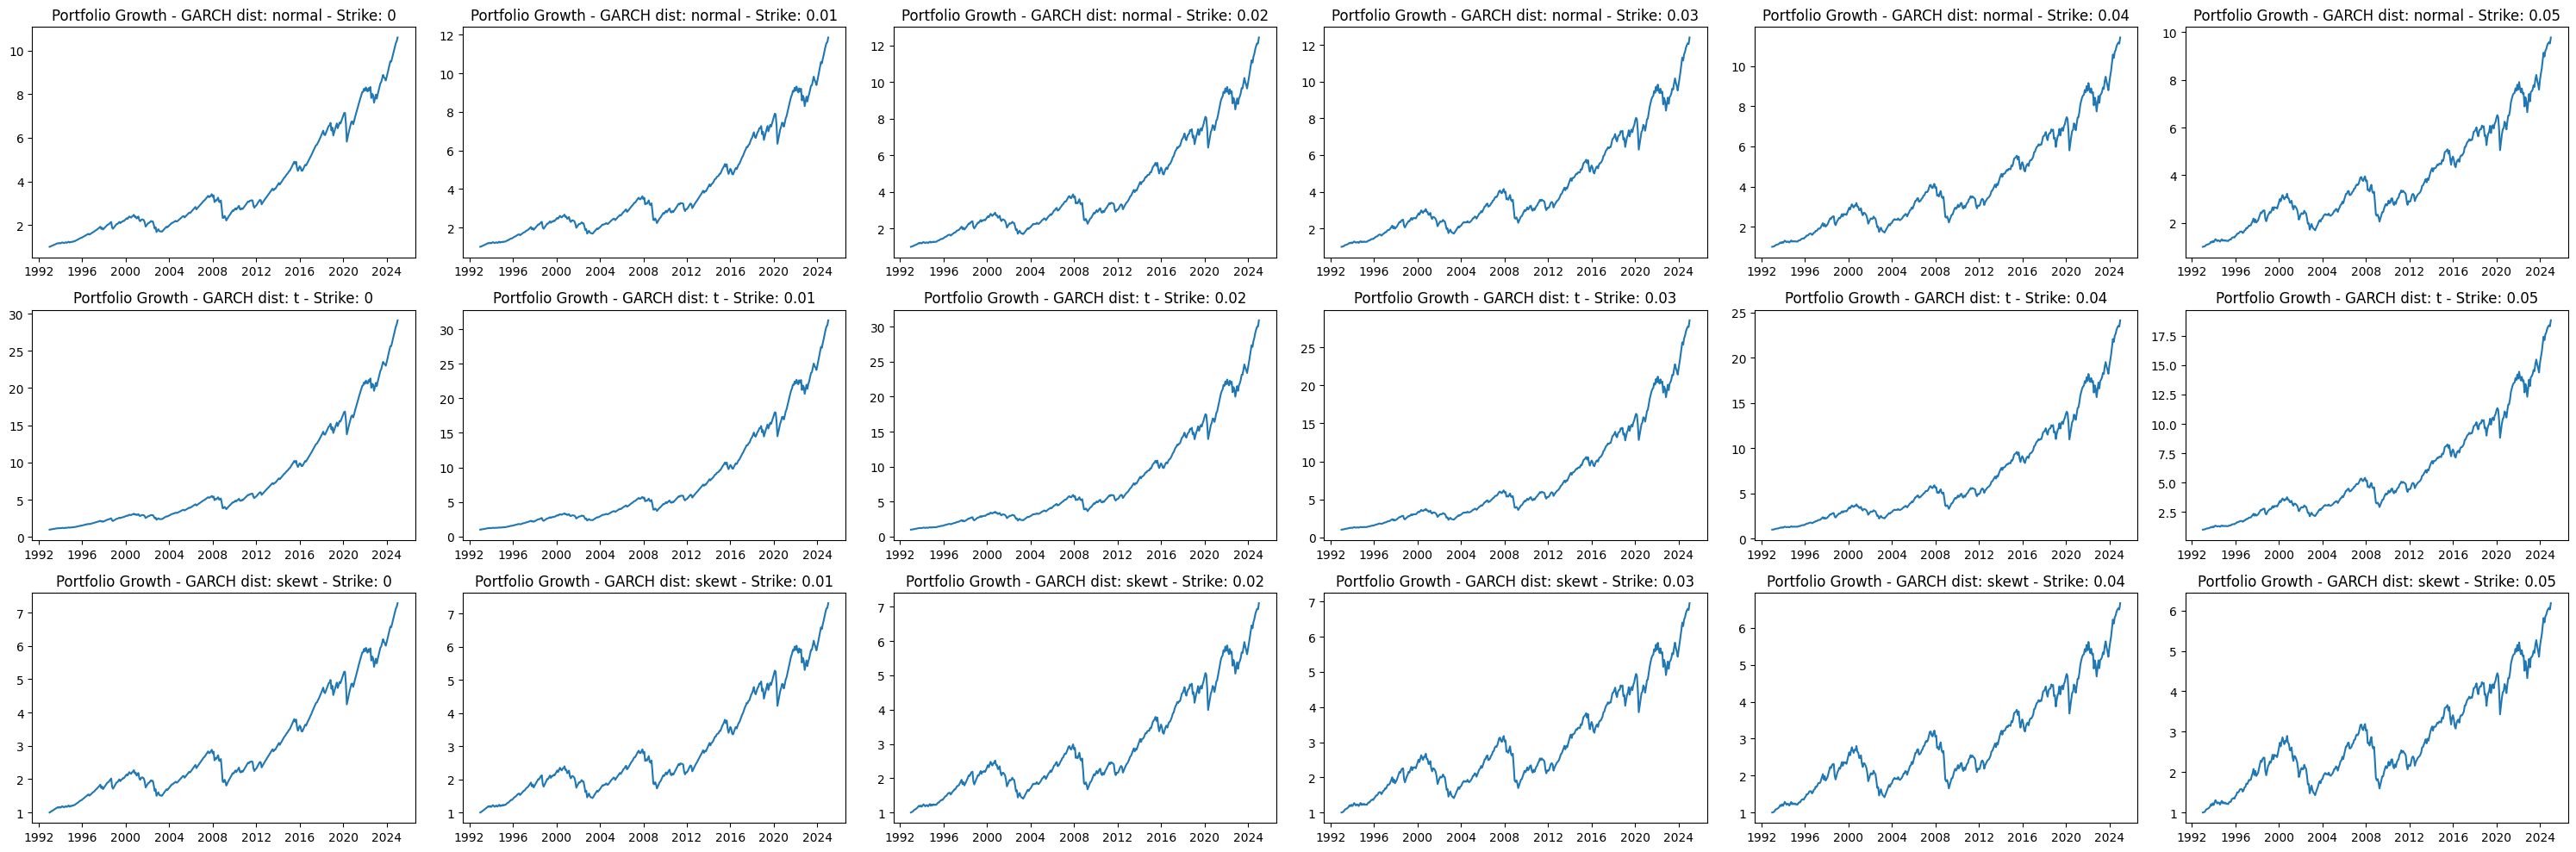

In [21]:
fig, axes = plt.subplots(3, len(strikes), figsize=(5 * len(strikes), 10))
for i in range(len(distributions)):
    dist = distributions[i]
    for j in range(len(strikes)):
        strike = strikes[j]
        axes[i][j].plot(merged_data[tickers].index,portfolio_value[dist][j])
        axes[i][j].set_title("Portfolio Growth - GARCH dist: "+dist+" - Strike: "+str(strike))
plt.tight_layout()

From the above graphs, it is clear that this strategy is worth analyzing more. Let us conclude by analysing the monthly returns, and comparing to that of our underlying indices.

In [59]:
portfolio_returns = {}

for dist in distributions:
    values  = pd.DataFrame(portfolio_value[dist].T,index = merged_data[tickers].index, columns = strikes)
    returns = pd.DataFrame(np.log(values.pct_change()+1),index = merged_data[tickers].index,columns = strikes)
    returns = returns.dropna()

    results_df = pd.DataFrame(index = ['mu','sigma','VaR95','ES95'], columns = strikes)
    results_df['benchmark'] = np.round(np.array([avg_return.mean(),
                                        avg_return.std(),
                                    np.quantile(avg_return,0.05), 
                                    avg_return[avg_return<np.quantile(avg_return,0.05)].mean()]),5)

    for k in strikes:
        results_df.loc['mu',k] = round(returns[k].mean(),5)
        results_df.loc['sigma',k] = round(returns[k].std(),5)
        results_df.loc['VaR95',k] = round(np.quantile(returns[k], 0.05),5)
        results_df.loc['ES95',k] = round(returns[returns[k] <= results_df.loc['VaR95',k]][k].mean(),5)
        t_stat, p_value = ttest_ind(returns[k], avg_return)
        results_df.loc['p-value',k] = round(p_value/2,5) if t_stat >0  else 1
    results_df = results_df.round(5)

    print("GARCH Dist:",dist)

    display(results_df)  


GARCH Dist: normal


,0.0,0.01,0.02,0.03,0.04,0.05,benchmark
mu,0.00615,0.00644,0.00656,0.00656,0.00634,0.00594,0.00481
sigma,0.02779,0.03091,0.03387,0.03651,0.03863,0.04012,0.04173
VaR95,-0.05365,-0.05921,-0.06351,-0.06672,-0.0692,-0.07092,-0.07294
ES95,-0.08627,-0.09201,-0.09671,-0.10041,-0.10325,-0.10536,-0.10420
p-value,0.2999,0.26885,0.26098,0.2679,0.29805,0.35096,NaN


GARCH Dist: t


,0.0,0.01,0.02,0.03,0.04,0.05,benchmark
mu,0.00878,0.00897,0.00893,0.00873,0.00829,0.00764,0.00481
sigma,0.02773,0.03084,0.03379,0.03642,0.03855,0.04004,0.04173
VaR95,-0.05145,-0.05718,-0.06164,-0.06495,-0.06728,-0.06904,-0.07294
ES95,-0.08324,-0.08906,-0.09389,-0.09778,-0.10082,-0.10316,-0.10420
p-value,0.06033,0.05822,0.06611,0.08258,0.11477,0.16839,NaN


GARCH Dist: skewt


,0.0,0.01,0.02,0.03,0.04,0.05,benchmark
mu,0.00517,0.00518,0.00511,0.00505,0.00494,0.00474,0.00481
sigma,0.02791,0.03105,0.034,0.03664,0.03875,0.04022,0.04173
VaR95,-0.0547,-0.06059,-0.065,-0.06813,-0.07052,-0.07204,-0.07294
ES95,-0.08765,-0.09374,-0.09869,-0.10247,-0.10523,-0.10711,-0.10420
p-value,0.44357,0.44395,0.45672,0.46581,0.48166,1,NaN


## Conclusion

Regardless of the distribution chosen for our GARCH residuals, we observed low heteroskedatics effects in our timeseries. We found that GARCH(1,1) model worked best for all choices of distribution, with a skewed Student's-t distribution offering the best fit. We found that a Student's-t copula could be closely fitted to the GARCH residuals, allowing us to conduct correlated multivariate volatility forecasts. While these forecasts are not a good indicator of future returns, they were still useful in pricing our basket options. Our basket options closely reflected the real world average payoffs. We found that a covered call strategy, with strike return less than or equal to 3%, offered us a greater return than investing equally in the underlying indices alone, with a lesser volatility, value at risk and expected shortfall. However, these last conclusions were not statistically significant.

# References

1. **Aroussi, R. (n.d.).** Yfinance. PyPI. [https://pypi.org/project/yfinance/](https://pypi.org/project/yfinance/)  

2. **Astanin, S. (n.d.).** Tabulate. PyPI. [https://pypi.org/project/tabulate/](https://pypi.org/project/tabulate/)  

3. **Cherubini, U., Luciano, E., & Vecchiato, W. (2004).** Copula Methods in Finance. [https://doi.org/10.1002/9781118673331](https://doi.org/10.1002/9781118673331)  

4. **Hansen, B. E. (1994).** Autoregressive conditional density estimation. *International Economic Review, 35*(3), 705. [https://doi.org/10.2307/2527081](https://doi.org/10.2307/2527081)  

5. **Harris, C. R., Millman, K. J., van der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., Wieser, E., Taylor, J., Berg, S., Smith, N. J., Kern, R., Picus, M., Hoyer, S., van Kerkwijk, M. H., Brett, M., Haldane, A., del Río, J. F., Wiebe, M., Peterson, P., … Oliphant, T. E. (2020).** Array programming with NumPy. *Nature, 585*(7825), 357–362. [https://doi.org/10.1038/s41586-020-2649-2](https://doi.org/10.1038/s41586-020-2649-2)  

6. **Hunter, J. D. (2007).** Matplotlib: A 2D graphics environment. *Computing in Science & Engineering, 9*(3), 90–95. [https://doi.org/10.1109/mcse.2007.55](https://doi.org/10.1109/mcse.2007.55)  

7. **The pandas development team. (2024, April 10).** Pandas-dev/Pandas: Pandas. Zenodo. [https://zenodo.org/records/10957263](https://zenodo.org/records/10957263)  

8. **Seabold, S., & Perktold, J. (2010).** Statsmodels: Econometric and statistical modeling with python. *Proceedings of the Python in Science Conference*, 92–96. [https://doi.org/10.25080/majora-92bf1922-011](https://doi.org/10.25080/majora-92bf1922-011)  

9. **Sheppard, K., Khrapov, S., Lipták, G., Mikedeltalima, Capellini, R., Alejandro-Cermeno, Hugle, Esvhd, bot, S., Fortin, A., Jpn, Judell, M., Russell, R., Li, W., 645775992, Adams, A., Jbrockmendel, Migrator, L., Rabba, M., … Çelik, B. (2023, September 26).** Bashtage/Arch: Release 6.1.0. Zenodo. [https://zenodo.org/record/7975104](https://zenodo.org/record/7975104)  

10. **Virtanen, P., Gommers, R., Oliphant, T. E., Haberland, M., Reddy, T., Cournapeau, D., Burovski, E., Peterson, P., Weckesser, W., Bright, J., van der Walt, S. J., Brett, M., Wilson, J., Millman, K. J., Mayorov, N., Nelson, A. R., Jones, E., Kern, R., Larson, E., … Vázquez-Baeza, Y. (2020).** SciPy 1.0: Fundamental algorithms for scientific computing in python. *Nature Methods, 17*(3), 261–272. [https://doi.org/10.1038/s41592-019-0686-2](https://doi.org/10.1038/s41592-019-0686-2)  
